# Install requirements

In [1]:
# %pip install deeplake
# %pip install matplotlib
# %pip install torch torchvision
# %pip install numpy
# %pip install counter
# %pip install keras-hub keras

%pip install torch_summary

Note: you may need to restart the kernel to use updated packages.


# Import libraries


In [2]:
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset
import deeplake
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
import random
import collections
from collections import Counter
import torch
from PIL import Image
import os, time

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchsummary import summary

e:\Python\Lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (4.2.14) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [3]:
os.environ["KERAS_BACKEND"] = "torch"  # or "tensorflow" or "torch"

# Load the Deeplake Wikiart Dataset

In [4]:
# Load the dataset
ds = deeplake.load('hub://activeloop/wiki-art') # Deep Lake Dataset

\

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/wiki-art



|

hub://activeloop/wiki-art loaded successfully.



# Preprocessing data

In [5]:
labels = [ds.labels[i].numpy(fetch_chunks=True).item() for i in range(len(ds))]
class_counts = Counter(labels)

# Get class names from dataset metadata
class_names = ds.labels.info['class_names']

print("Number of images per class:")
for class_id, count in class_counts.items():
    print(f"{class_names[class_id]}: {count}")

e:\Python\Lib\site-packages\deeplake\core\tensor.py:719: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


Number of images per class:
abstract_expressionism: 2782
action_painting: 98
analytical_cubism: 110
art_nouveau_modern: 4328
baroque: 4241
color_field_painting: 1615
contemporary_realism: 481
cubism: 2235
early_renaissance: 1391
expressionism: 6736
fauvism: 934
high_renaissance: 1343
impressionism: 13060
mannerism_late_renaissance: 1279
minimalism: 1337
naive_art_primitivism: 2405
new_realism: 314
northern_renaissance: 2550
pointillism: 513
pop_art: 1483
post_impressionism: 6451
realism: 10733
rococo: 2089
romanticism: 7015
symbolism: 4527
synthetic_cubism: 216
ukiyo_e: 1167


Classes has unbalanced number of images

So classes with less than 4000 images will be removed

sampling 4000 images from each class

In [6]:
labels = [ds.labels[i].numpy(fetch_chunks=True).item() for i in range(len(ds))]
class_counts = Counter(labels)

valid_classes = [class_id for class_id, count in class_counts.items() if count >= 4000] # Filter classes with at leas 4000 images

# Collect indices forr each valid class

class_indices = {class_id: [] for class_id in valid_classes}
for idx, label in enumerate(labels):
    if label in valid_classes:
        class_indices[label].append(idx)

# Sample 4000 images from each class
sampled_indices = []
for class_id in valid_classes:
    selected_indices = random.sample(class_indices[class_id], 4000)
    sampled_indices.extend(selected_indices)
    


In [7]:
filtered_labels = [labels[i] for i in sampled_indices]
filtered_class_counts = Counter(filtered_labels)

total_image = 0

print(f"Number of classes: {len(filtered_class_counts)}")
print("Class information:")
for class_id, count in filtered_class_counts.items():
    total_image += count
    print(f" {class_names[class_id]}: {count} images")

print(f"Total: {total_image} images")

Number of classes: 8
Class information:
 art_nouveau_modern: 4000 images
 baroque: 4000 images
 expressionism: 4000 images
 impressionism: 4000 images
 post_impressionism: 4000 images
 realism: 4000 images
 romanticism: 4000 images
 symbolism: 4000 images
Total: 32000 images


# Define transformation function and dataset

In [8]:
# Transform function
tform = transforms.Compose([
    transforms.ToPILImage(), # Must convert to PIL image for subsequent operations to run
    # transforms.RandomRotation(20), # Image augmentation
    transforms.Resize((224, 224)),
    transforms.ToTensor(), # Must convert to pytorch tensor for subsequent operations to run
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

valid_classes = sorted([class_id for class_id, count in class_counts.items() if count >= 4000])
label_map = {raw_label: idx for idx, raw_label in enumerate(valid_classes)}
# Define dataset
class ArtDataset(Dataset):
    def __init__(self, ds, indices, label_map ,transform=None):
        self.ds = ds
        self.indices = indices
        self.transform = transform
        self.label_map = label_map

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        image = self.ds.images[real_idx].numpy()

        raw_label = self.ds.labels[real_idx].numpy(fetch_chunks=True)
        raw_label = int(raw_label[0]) if isinstance(raw_label, np.ndarray) else int(raw_label)

        if raw_label not in self.label_map:
            raise ValueError(f"Invalid label: {raw_label} at index {real_idx}")

        label = self.label_map[raw_label]  # mapped to 0–7

        if self.transform:
            image = self.transform(image)

        return {"images": image, "labels": torch.tensor(label, dtype=torch.long)}

After processing data, we have total 8 classes with 32000 images, 4000 images for each class

### Visualize some data from dataset

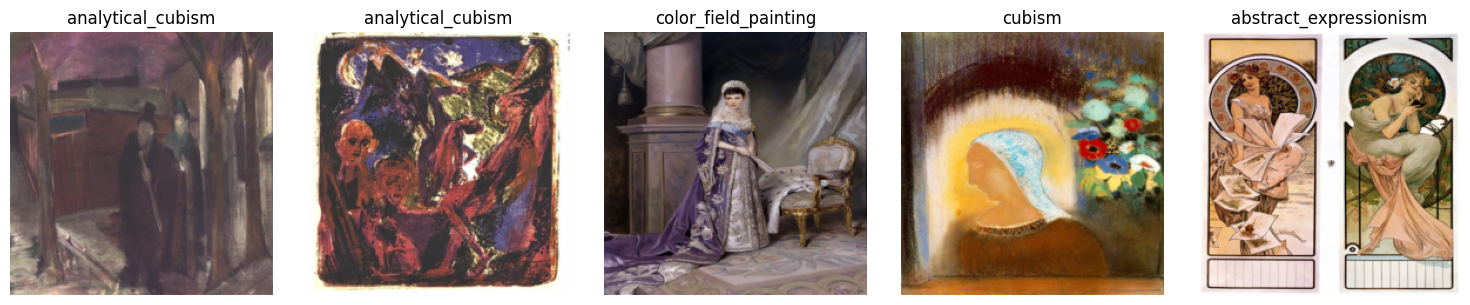

In [9]:

data_loader = ArtDataset(ds, sampled_indices, label_map, tform)

# Get class names from dataset metadata
class_names = ds.labels.info['class_names']

# Plot 5 random samples from the filtered dataset
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    sample = data_loader[random.randint(0, len(data_loader)-1)]
    image = sample["images"]
    label = sample["labels"].item() if hasattr(sample["labels"], "item") else int(sample["labels"])
    # Unnormalize for display
    image = image.numpy().transpose(1, 2, 0) * 0.5 + 0.5
    axs[i].imshow(image)
    axs[i].set_title(class_names[label])
    axs[i].axis('off')
plt.tight_layout()
plt.show()

# Split data



In [10]:

# Map: class_id -> list of corresponding sampled indices
class_to_sampled = defaultdict(list)

for idx in sampled_indices:
    label = ds.labels[idx].numpy(fetch_chunks=True).item()
    class_to_sampled[label].append(idx)

train_ratio = 0.8
# val_ratio = 0.0
test_ratio = 0.2

# train_indices, val_indices, test_indices = [], [], []
train_indices, test_indices = [], []

for class_id, indices in class_to_sampled.items():
    random.shuffle(indices)
    n = len(indices)
    n_train = int(train_ratio * n)
    # n_val = int(val_ratio * n)

    train_indices.extend(indices[:n_train])
    # val_indices.extend(indices[n_train:n_train + n_val])
    test_indices.extend(indices[n_train:])

In [11]:
def print_split_info(indices, split_name):
    split_labels = [ds.labels[i].numpy(fetch_chunks=True).item() for i in indices]
    split_counts = Counter(split_labels)
    print(f"{split_name} split:")
    for class_id, count in split_counts.items():
        print(f"  {class_names[class_id]}: {count} images")
    print(f"Total: {sum(split_counts.values())} images\n")

print_split_info(train_indices, "Train")
# print_split_info(val_indices, "Validation")
print_split_info(test_indices, "Test")

Train split:
  art_nouveau_modern: 3200 images
  baroque: 3200 images
  expressionism: 3200 images
  impressionism: 3200 images
  post_impressionism: 3200 images
  realism: 3200 images
  romanticism: 3200 images
  symbolism: 3200 images
Total: 25600 images

Test split:
  art_nouveau_modern: 800 images
  baroque: 800 images
  expressionism: 800 images
  impressionism: 800 images
  post_impressionism: 800 images
  realism: 800 images
  romanticism: 800 images
  symbolism: 800 images
Total: 6400 images



### Create dataset and data loader from indices

In [ ]:
train_dataset = ArtDataset(ds, train_indices, label_map, transform=tform)
# val_dataset   = ArtDataset(ds, val_indices, transform=tform)
test_dataset  = ArtDataset(ds, test_indices, label_map, transform=tform)

train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=4, pin_memory=True)
# val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=200, shuffle=True, num_workers=4, pin_memory=True)

# Train model


In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Model 1: ResNet18

Trained on: GPU RTX 3060 12GB

In [14]:
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 8))
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

model, criterion, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224))

e:\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

In [15]:
num_epochs = 4

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        inputs = batch["images"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



e:\Python\Lib\site-packages\deeplake\core\tensor.py:719: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        inputs = batch["images"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Accuracy: {correct / total:.2%}")